In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as opt

import pandas as pd
import random
import requests

import matplotlib.pyplot as plt

In [4]:
csv_url = 'https://huggingface.co/datasets/readerbench/ro-stories/resolve/main/ro_paragraphs_12516.csv'

res = requests.get(csv_url)
csv_content = res.content.decode('utf-8')

filename = 'ro_paragraphs.csv'
with open(filename, 'w', encoding='utf-8') as file:
    file.write(csv_content)

df = pd.read_csv(filename)

In [5]:
SAMPLE_COUNT = 500
threshold_authors = {k: v for k, v in df.author.value_counts().items() if v > SAMPLE_COUNT}
authortoi = {a: i for i, a in enumerate(threshold_authors)}
itoauthor = {i: a for a, i in authortoi.items()}
paragraphs = []
authors = []
n_classes = len(threshold_authors)

# Sample some SAMPLE_COUNT number of paragraphs for each author
for author, count in threshold_authors.items():
    rows = df.loc[df['author'] == author, 'paragraph']
    paragraphs += (random.sample(rows.tolist(), SAMPLE_COUNT))
    authors += ([author] * SAMPLE_COUNT)

In [6]:
class LetterTokenizer:
    def __init__(self, txt):
        self.letters = list(set(''.join(txt)))
        self.vocab_size = len(self.letters)
        self.token_to_id = {char: idx for idx, char in enumerate(self.letters)}
        self.id_to_token = {idx: char for idx, char in enumerate(self.letters)}
        self.pad_token_id = self.token_to_id[" "]  # Using space as pad token

    def encode(self, text):
        text = text.lower()  # Convert text to lowercase for caseless operation
        return [self.token_to_id[char] for char in text if char in self.token_to_id]

    def decode(self, token_ids):
        return "".join([self.id_to_token[token_id] for token_id in token_ids])

In [7]:
tok = LetterTokenizer(paragraphs)
INPUT_LEN = 350
CTX_LEN = 105

def uniformize_length(paragraph, length, rev = False):
  if len(paragraph) > length:
    # Truncate the paragraph if it is longer than the desired length
    return paragraph[:length] if rev == False else paragraph[-length:]
  else:
    # Pad the paragraph with tokenizer.pad_token_id if it is shorter than the desired length
    return (paragraph + [tok.pad_token_id] * (length - len(paragraph))) if rev == False else ([tok.pad_token_id] * (length - len(paragraph)) + paragraph)

inputs = [uniformize_length(tok.encode(p), INPUT_LEN) for p in paragraphs]
outputs = [authortoi[a] for a in authors]

inputs = torch.tensor(inputs)
outputs = torch.tensor(outputs)

In [8]:
class ClassifierModel(nn.Module):
  def __init__(self, n_neurons):
    super().__init__()

    self.nn = n_neurons
    self.l1 = nn.Linear(CTX_LEN * tok.vocab_size, n_neurons)
    self.activation = nn.SELU()
    self.softmax = nn.Softmax()
    self.l2 = nn.Linear(n_neurons, n_classes)

  def forward(self, x):
    x = self.activation(self.l1(x))
    x = self.softmax(self.l2(x))
    return x

In [9]:
N_HIDDEN_NEURONS = 1000
model = ClassifierModel(N_HIDDEN_NEURONS)

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
losses = []
model.to(device)

ClassifierModel(
  (l1): Linear(in_features=14805, out_features=1000, bias=True)
  (activation): SELU()
  (softmax): Softmax(dim=None)
  (l2): Linear(in_features=1000, out_features=8, bias=True)
)

Mihail Sebastian


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Current loss=1.2952086560580205, Average loss=0.006476043280290103
Mihail Sebastian


KeyboardInterrupt: 

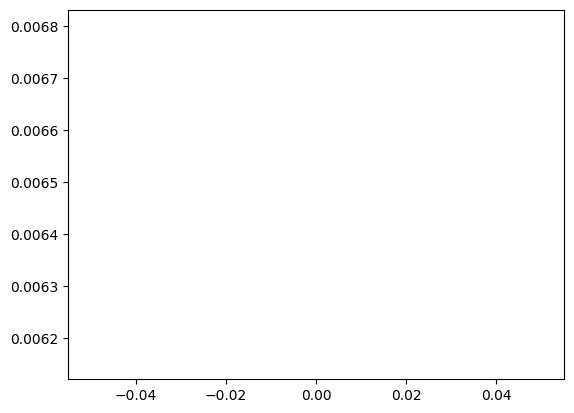

In [10]:
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), LR)

N_EPOCHS = 1
BLOCK_COUNT = 200
avg_loss = 0
for epoch in range(N_EPOCHS):
  indexes = random.sample(range(len(inputs)), BLOCK_COUNT)
  for batch in indexes:
    print(authors[batch])
    target_t = outputs[batch].to(device)
    target_t = nnf.one_hot(target_t, num_classes=n_classes).float()

    batch_loss = 0
    for i in range(inputs.shape[1] - CTX_LEN):
      optimizer.zero_grad()

      input_t = inputs[batch, i:(i + CTX_LEN)].to(device)
      input_t = nnf.one_hot(input_t, num_classes=tok.vocab_size).float()
      input_t = input_t.flatten()

      # Forward pass
      output = model(input_t)
      loss = criterion(output, target_t)

      # Backward pass
      loss.backward()
      optimizer.step()
      batch_loss += loss.item() / (inputs.shape[1] - CTX_LEN)
    avg_loss += batch_loss
    losses.append(avg_loss / BLOCK_COUNT)
    plt.plot(losses)

    print(f"Current loss={batch_loss}, Average loss={avg_loss / BLOCK_COUNT}")

In [11]:
paragraph_idx = 1499
input_str = 'Curat caraghioz!... Pardon, să iertați, coane Fănică, că întreb: bambir... ce-i aia, bampir?' if paragraph_idx == -1 else paragraphs[paragraph_idx]

input_t = torch.tensor(uniformize_length(tok.encode(input_str), CTX_LEN))
input_t = nnf.one_hot(input_t, num_classes=tok.vocab_size).float()
input_t = torch.flatten(input_t).to(device)

output_t = model(input_t)

output_val = nnf.softmax(output_t).tolist()
print(input_str)
if paragraph_idx != -1:
  print(authors[paragraph_idx])
print()

for i in range(len(output_val)):
  print(f"{output_val[i] * 100:.1f}%, {itoauthor[i]}")

Uneori, ca și Allah, dau în părinte și izbesc în copii! Ai mei însă habar nu au, nu numai un pom din grădina mea are la rădăcină ulcior din cari se adapă. Orbul începu să rîză. Un turc, care se pripășise de cîtăva vreme în oraș, se roși și șopti: — A înnebunit bietul bătrîn! Apoi se întoarse către cei cari ferbeau cafelele în ibrice galbene cu cozi lungi și le zise: O cafea giaba lui Giaba-efendi! Giaba-efendi nu mai auzise acest glas. Tresări. Și cum începu să soarbă, să înecă, tuși, vărsă jumătate cafeaua pe el, apoi puse ceașca pe masă și zise încet băiatului care îi adusese cafeaua: — Du-mă la cine m-a cinstit… Aș vrea să-i mulțumesc… Băiatul îl duse. Îndată ce Giaba-efendi apucă de mînă pe necunoscut, se agăță de el și începu să strige: — Efendi, efendi, oameni buni, Allah să vă apere lumina ochilor ca să vedeți cine vine în spatele vostru! El mi-a furat comoara! Cafeaua d-adineauri n-a fost giaba… toată viața mea am băut giaba și nu m-am înecat… azi am băut din banii mei și m-am 

<ipython-input-11-60b0924d0379>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_val = nnf.softmax(output_t).tolist()
